In [71]:
import torch
import torch.nn as nn
from torch_snippets import *
from torchvision import transforms
from sklearn.model_selection import train_test_split
device = 'cuda' if torch.cuda.is_available() else 'cpu'
import cv2
import os
import matplotlib.pyplot as plt
from PIL import Image
import os

# data preprocessing

In [60]:
source_training_folder=r'C:\myfiles\bone suppression\augmented\augmented\train_source'
list=os.listdir(source_training_folder)
count=1
for i in range (4080):
    os.rename(os.path.join(source_training_folder,list[i]),os.path.join(source_training_folder,'{}.png'.format(count)))
    count+=1
    

In [63]:
target_training_folder=r'C:\myfiles\bone suppression\augmented\augmented\train_target'
list=os.listdir(target_training_folder)
count=1
for i in range (4080):
    os.rename(os.path.join(target_training_folder,list[i]),os.path.join(target_training_folder,'{}.png'.format(count)))
    count+=1
    

In [64]:
import random
all_source_files = Glob(r'C:\myfiles\bone suppression\augmented\augmented\train_source/*.png')
list_of_test=random.sample(range(1, 4080), 408)
for i in range (408):
    temp=cv2.imread(str(all_target_files[list_of_test[i]]))
    cv2.imwrite(r'C:\myfiles\bone suppression\augmented\augmented\test_source\{}.jpg'.format(list_of_test[i]),temp)

2021-12-17 15:36:49.903 | INFO     | torch_snippets.paths:inner:24 - 4080 files found at C:\myfiles\bone suppression\augmented\augmented\train_source/*.png


In [66]:
for i in range(408):
    os.remove(r'C:\myfiles\bone suppression\augmented\augmented\train_source'+'/'+'{}.png'.format(list_of_test[i]))

In [67]:
all_target_files = Glob(r'C:\myfiles\bone suppression\augmented\augmented\train_target/*.png')
for i in range (408):
    temp=cv2.imread(str(all_target_files[list_of_test[i]]))
    cv2.imwrite(r'C:\myfiles\bone suppression\augmented\augmented\test_target\{}.png'.format(list_of_test[i]),temp)

2021-12-17 15:41:10.189 | INFO     | torch_snippets.paths:inner:24 - 4080 files found at C:\myfiles\bone suppression\augmented\augmented\train_target/*.png


In [68]:
for i in range(408):
    os.remove(r'C:\myfiles\bone suppression\augmented\augmented\train_target'+'/'+'{}.png'.format(list_of_test[i]))

# create the bone images dataset

In [72]:
class bone_dataset(Dataset):
    def __init__(self,name):
        if name=='train':
            self.name=name
            self.folder=r'C:\myfiles\bone suppression\augmented\augmented'
            self.source_items=os.listdir(r'C:\myfiles\bone suppression\augmented\augmented\train_source')
            self.target_items=os.listdir(r'C:\myfiles\bone suppression\augmented\augmented\train_target')
        elif name=='test':
            self.name=name
            self.folder=r'C:\myfiles\bone suppression\augmented\augmented'
            self.source_items=os.listdir(r'C:\myfiles\bone suppression\augmented\augmented\test_source')
            self.target_items=os.listdir(r'C:\myfiles\bone suppression\augmented\augmented\test_target')
                
        
    def __getitem__(self,ix):
        if self.name=='train':
            source=cv2.imread(os.path.join(self.folder,'train_source',self.source_items[ix]))
            target=cv2.imread(os.path.join(self.folder,'train_target',self.target_items[ix]))
            source=cv2.resize(source,(400,400))
            kernel = np.array([[0, -1, 0],
                              [-1, 5,-1],
                             [0, -1, 0]])
            source = cv2.filter2D(src=source, ddepth=-1, kernel=kernel)
            target=cv2.resize(target,(400,400))
            target = cv2.filter2D(src=target, ddepth=-1, kernel=kernel)
            source=torch.Tensor(source).permute(2,0,1)
            #source=source/255.
            target=torch.Tensor(target).permute(2,0,1)
            #target=target/255.
            source=source.to(device)
            target=target.to(device)
            return source , target
        
        if self.name=='test':
            source=cv2.imread(os.path.join(self.folder,'test_source',self.source_items[ix]))
            target=cv2.imread(os.path.join(self.folder,'test_target',self.target_items[ix]))
            source=cv2.resize(source,(400,400))
            kernel = np.array([[0, -1, 0],
                              [-1, 5,-1],
                             [0, -1, 0]])
            source = cv2.filter2D(src=source, ddepth=-1, kernel=kernel)
            target=cv2.resize(target,(400,400))
            target = cv2.filter2D(src=target, ddepth=-1, kernel=kernel)
            source=torch.Tensor(source).permute(2,0,1)
            #source=source/255.
            target=torch.Tensor(target).permute(2,0,1)
            #target=target/255.
            source=source.to(device)
            target=target.to(device)
            return source , target
        
        
    def __len__(self):
        return len(self.source_items)   
           

# make training and validation dataloader

In [73]:
trn_ds=bone_dataset('train')
val_ds=bone_dataset('test')
trn_dl = DataLoader(trn_ds, batch_size=8, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=1, shuffle=True)



# make autoencoder model

In [74]:
class CDAutoEncoder(nn.Module):
    
    def __init__(self, input_size, output_size, stride):
        super(CDAutoEncoder, self).__init__()

        self.forward_pass = nn.Sequential(
            nn.Conv2d(input_size, output_size, kernel_size=2, stride=stride, padding=0),
            nn.ReLU(),
            nn.Conv2d(output_size,output_size*2,kernel_size=2, stride=stride, padding=0),
            nn.ReLU(),
            nn.Conv2d(output_size*2,output_size*4,kernel_size=2, stride=stride, padding=0),
            nn.ReLU()
        )
        self.backward_pass = nn.Sequential(
            nn.ConvTranspose2d(output_size*4, output_size*2, kernel_size=2, stride=2, padding=0), 
            nn.ReLU(),
            nn.ConvTranspose2d(output_size*2, output_size, kernel_size=2, stride=2, padding=0), 
            nn.ReLU(),
            nn.ConvTranspose2d(output_size, input_size, kernel_size=2, stride=2, padding=0), 
            nn.ReLU()
        )


    def forward(self, x):
        # Train each autoencoder individually
        #x = x.detach()
        y = self.forward_pass(x)    
        x_reconstruct = self.backward_pass(y)
        return x_reconstruct
        
    def reconstruct(self, x):
        return self.backward_pass(x)   
    
class StackedAutoEncoder(nn.Module):

    def __init__(self):
        super(StackedAutoEncoder, self).__init__()

        self.ae1 = CDAutoEncoder(3,128, 2)
       
    def forward(self, x):
        a1 = self.ae1(x)
 

        return  a1
       
model =  StackedAutoEncoder().to(device)

In [76]:
from torchsummary import summary
summary(model, torch.zeros(1,3,400,400));

Layer (type:depth-idx)                   Output Shape              Param #
├─CDAutoEncoder: 1-1                     [-1, 3, 400, 400]         --
|    └─Sequential: 2-1                   [-1, 512, 50, 50]         --
|    |    └─Conv2d: 3-1                  [-1, 128, 200, 200]       1,664
|    |    └─ReLU: 3-2                    [-1, 128, 200, 200]       --
|    |    └─Conv2d: 3-3                  [-1, 256, 100, 100]       131,328
|    |    └─ReLU: 3-4                    [-1, 256, 100, 100]       --
|    |    └─Conv2d: 3-5                  [-1, 512, 50, 50]         524,800
|    |    └─ReLU: 3-6                    [-1, 512, 50, 50]         --
|    └─Sequential: 2-2                   [-1, 3, 400, 400]         --
|    |    └─ConvTranspose2d: 3-7         [-1, 256, 100, 100]       524,544
|    |    └─ReLU: 3-8                    [-1, 256, 100, 100]       --
|    |    └─ConvTranspose2d: 3-9         [-1, 128, 200, 200]       131,200
|    |    └─ReLU: 3-10                   [-1, 128, 200, 200]  

# define train batch and validate batch functions

In [77]:
def train_batch(source,target, model, criterion, optimizer):
    model.train()
    optimizer.zero_grad()
    output = model(source)
    loss = criterion(output,target)
    loss.backward()
    optimizer.step()
    return loss



@torch.no_grad()
def validate_batch(source,target, model, criterion):
    model.eval()
    output = model(source)
    loss = criterion(output,target)
    return loss



In [78]:
from pytorch_msssim import ssim, ms_ssim, SSIM, MS_SSIM

# define structural similarity loss function

In [79]:
class MS_SSIM_Loss(MS_SSIM):
    def forward(self, img1, img2):
        return 100*( 1 - super(MS_SSIM_Loss, self).forward(img1, img2) )


# define total loss as combination of mean squared error and structural similarity

In [80]:
ce = nn.MSELoss()
def UnetLoss(preds, targets):
    ce_loss = ce(preds, targets)
    return ce_loss

def total_loss(pred,target):
    r1=UnetLoss(pred,target)
    r2= 1 - ms_ssim(pred,target, data_range=255, size_average=True )
    return  0.16*r1+0.84*r2
    
    

In [81]:
model = StackedAutoEncoder().to(device)
criterion = total_loss
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-5)

# train the model

In [82]:


num_epochs = 20
log = Report(num_epochs)


for epoch in range(num_epochs):
    N = len(trn_dl)
    for ix, (source,target) in enumerate(trn_dl):
        loss = train_batch(source,target, model, criterion, optimizer)
        log.record(pos=(epoch + (ix+1)/N), trn_loss=loss, end='\r')
        
    N = len(val_dl)
    for ix, (source,target) in enumerate(val_dl):
        loss = validate_batch(source,target, model, criterion)
        log.record(pos=(epoch + (ix+1)/N), val_loss=loss, end='\r')
        
    log.report_avgs(epoch+1)

EPOCH: 1.000	trn_loss: 41.600	val_loss: 17.045	(466.15s - 8856.85s remaining)
EPOCH: 2.000	trn_loss: 16.432	val_loss: 16.800	(784.39s - 7059.48s remaining)
EPOCH: 3.000	trn_loss: 14.236	val_loss: 12.470	(962.09s - 5451.86s remaining)
EPOCH: 4.000	trn_loss: 12.988	val_loss: 12.855	(1133.08s - 4532.30s remaining)
EPOCH: 5.000	trn_loss: 13.119	val_loss: 11.658	(1303.87s - 3911.61s remaining)
EPOCH: 6.000	trn_loss: 12.520	val_loss: 14.785	(1470.98s - 3432.30s remaining)
EPOCH: 7.000	trn_loss: 12.390	val_loss: 11.559	(1641.13s - 3047.81s remaining)
EPOCH: 8.000	trn_loss: 12.235	val_loss: 13.105	(1817.51s - 2726.27s remaining)
EPOCH: 9.000	trn_loss: 12.167	val_loss: 13.456	(1993.63s - 2436.65s remaining)
EPOCH: 10.000	trn_loss: 12.049	val_loss: 11.297	(2170.01s - 2170.01s remaining)
EPOCH: 11.000	trn_loss: 12.284	val_loss: 14.665	(2342.23s - 1916.37s remaining)
EPOCH: 12.000	trn_loss: 12.016	val_loss: 11.826	(2513.31s - 1675.54s remaining)
EPOCH: 13.000	trn_loss: 12.057	val_loss: 11.860	(268

# display the predicted image on random image

In [147]:
ix = np.random.randint(len(val_ds))
im, _ = val_ds[ix]
_im = model(im[None])[0]

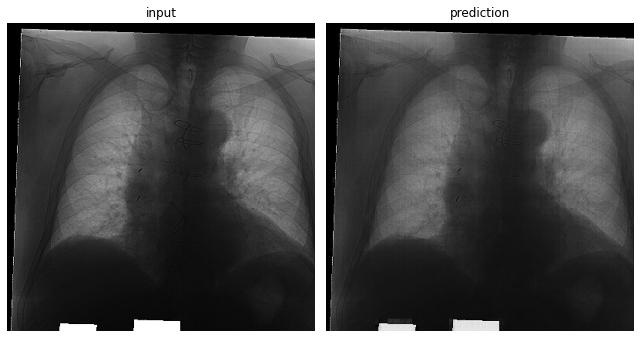

In [148]:
fig, ax = plt.subplots(1, 2, figsize=(9,9))
show(im[0], ax=ax[0], title='input')
show(_im[0], ax=ax[1], title='prediction')
plt.tight_layout()
plt.show()